In [2]:
# fix for my pc os error
import os

from torch.backends.quantized import engine

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [32]:
import torch
import torchvision
from torch import nn
from torchvision.datasets import ImageFolder
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
from pathlib import Path
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [57]:
data_dir = Path("data/traffic_Data/DATA")
temp_data = list(data_dir.glob("*/*.png")
                 )
label_to_sign = pd.read_csv("data/labels.csv")
label_to_sign["Name"][17]

'No horn'

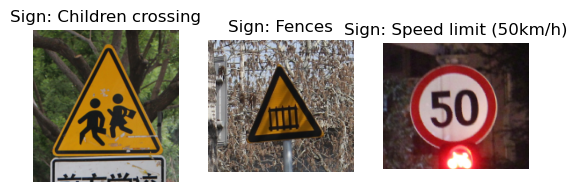

In [63]:
# Visualising 3 random images from data set
import random
plt.subplots(nrows=1,ncols=3)

for i in range(3):
    random_idx = random.randint(0,len(temp_data)-1)
    img = Image.open(temp_data[random_idx])
    label = temp_data[random_idx].parent.name
    plt.subplot(1,3,i+1)
    plt.title(f"Sign: {label_to_sign["Name"][int(label)]}")
    plt.imshow(img)
    plt.axis(False)


In [64]:
from torchvision.transforms import InterpolationMode

# Getting model and weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),  # Crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [65]:
# Getting Data
dataset = ImageFolder(root="data/traffic_Data/DATA",
                      transform=transform)

# Splitting into train and test DataSets
train_data,test_data = torch.utils.data.random_split(dataset,[0.8,0.2],torch.Generator().manual_seed(42))
len(train_data),len(test_data)

(3336, 834)

In [66]:
#Setting up data loaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=True,pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,batch_size=32,shuffle=False,pin_memory=True)
len(train_dataloader),len(test_dataloader)


(105, 27)

In [67]:
from engine import train
# getting optimizer and loss_fn
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()
# training for 5 epochs
model_results = train(model,train_dataloader,test_dataloader,optimizer,loss_fn,5,device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7855 | train_acc: 0.8503 | test_loss: 0.1210 | test_acc: 0.9653
Epoch: 2 | train_loss: 0.0533 | train_acc: 0.9863 | test_loss: 0.0193 | test_acc: 0.9965
Epoch: 3 | train_loss: 0.0310 | train_acc: 0.9920 | test_loss: 0.0145 | test_acc: 0.9977
Epoch: 4 | train_loss: 0.0633 | train_acc: 0.9836 | test_loss: 0.0409 | test_acc: 0.9896
Epoch: 5 | train_loss: 0.0369 | train_acc: 0.9896 | test_loss: 0.0218 | test_acc: 0.9942


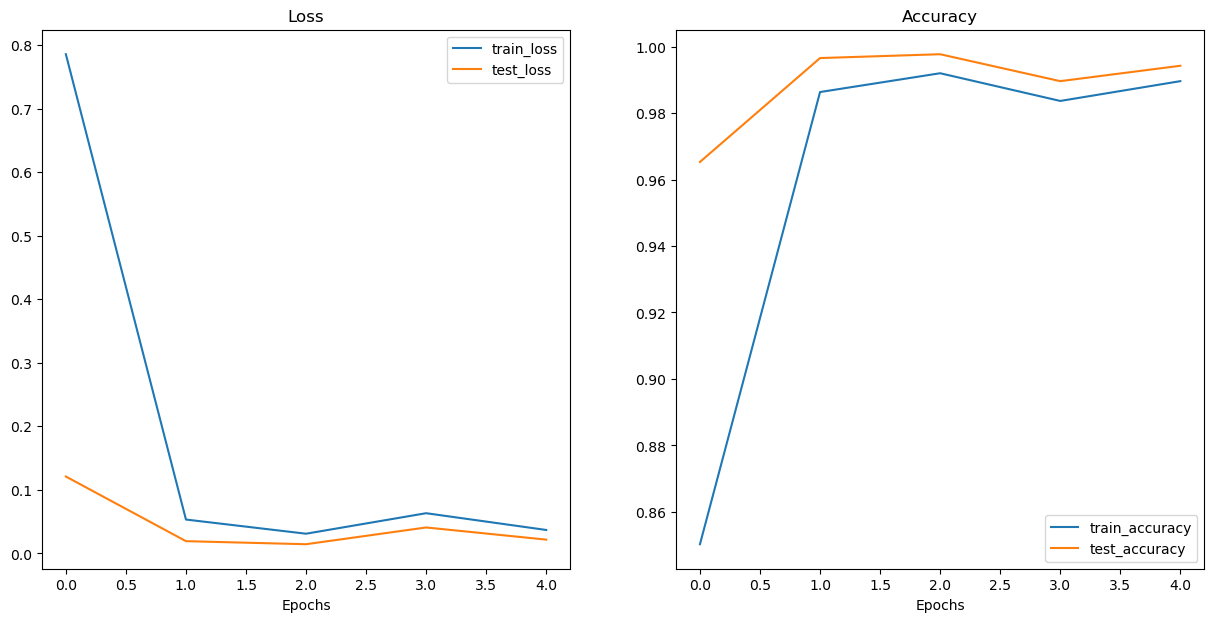

In [68]:
from helper_functions import plot_loss_curves, pred_and_plot_image

plot_loss_curves(model_results)